Business Analytics Model On a sales Dataset using the Random Forest Classifier

In [70]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.cluster import KMeans
import joblib

In [71]:
df = pd.read_csv('SampleSuperstore.csv')

In [72]:
print(df.isnull().sum()) #identifying missing values

Ship Mode       0
Segment         0
Country         0
City            0
State           0
Postal Code     0
Region          0
Category        0
Sub-Category    0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ship Mode     9994 non-null   object 
 1   Segment       9994 non-null   object 
 2   Country       9994 non-null   object 
 3   City          9994 non-null   object 
 4   State         9994 non-null   object 
 5   Postal Code   9994 non-null   int64  
 6   Region        9994 non-null   object 
 7   Category      9994 non-null   object 
 8   Sub-Category  9994 non-null   object 
 9   Sales         9994 non-null   float64
 10  Quantity      9994 non-null   int64  
 11  Discount      9994 non-null   float64
 12  Profit        9994 non-null   float64
dtypes: float64(3), int64(2), object(8)
memory usage: 1015.1+ KB


In [74]:
df. head(5)

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164


In [75]:
df.Category.unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [76]:
df["Sub-Category"].unique()

array(['Bookcases', 'Chairs', 'Labels', 'Tables', 'Storage',
       'Furnishings', 'Art', 'Phones', 'Binders', 'Appliances', 'Paper',
       'Accessories', 'Envelopes', 'Fasteners', 'Supplies', 'Machines',
       'Copiers'], dtype=object)

In [77]:
df['Price'] = df['Sales'] / df['Quantity']

In [78]:
# For demand elasticity we want to see how changes in price affect quantity sales.
# Create log-transformed features:
df['log_Quantity'] = np.log(df['Quantity'])
df['log_Price'] = np.log(df['Sales'])
# Note: In a log-log (elasticity) regression, the coefficient on log_Price represents elasticity.

In [79]:
competitor_df = pd.read_csv('sales_dataset.csv')

In [80]:
competitor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Order ID      1194 non-null   object
 1   Amount        1194 non-null   int64 
 2   Profit        1194 non-null   int64 
 3   Quantity      1194 non-null   int64 
 4   Category      1194 non-null   object
 5   Sub-Category  1194 non-null   object
 6   PaymentMode   1194 non-null   object
 7   Order Date    1194 non-null   object
 8   CustomerName  1194 non-null   object
 9   State         1194 non-null   object
 10  City          1194 non-null   object
 11  Year-Month    1194 non-null   object
dtypes: int64(3), object(9)
memory usage: 112.1+ KB


In [81]:
competitor_df['Price'] = competitor_df['Amount'] / competitor_df['Quantity']

In [82]:
competitor_df['Order Date'] = pd.to_datetime(competitor_df['Order Date'])

# Step 2: Extract Day, Month, and Year into new columns
# df['Order Day'] = df['Order Date'].dt.day
competitor_df['Order Month'] = competitor_df['Order Date'].dt.month
competitor_df['Order Year'] = competitor_df['Order Date'].dt.year

In [83]:
competitor_df.drop(columns=['Order ID', 'CustomerName', 'PaymentMode', 'Year-Month', 'Order Month', 'Order Date'],inplace=True)

In [84]:
print(competitor_df.isnull().sum()) #identifying missing values

Amount          0
Profit          0
Quantity        0
Category        0
Sub-Category    0
State           0
City            0
Price           0
Order Year      0
dtype: int64


In [85]:
df_join = df.merge(competitor_df, how='left', on=['Category', 'Sub-Category'])

In [86]:
df_join

,Ship Mode,Segment,Country,City_x,State_x,Postal Code,Region,Category,Sub-Category,Sales,...,Price_x,log_Quantity,log_Price,Amount,Profit_y,Quantity_y,State_y,City_y,Price_y,Order Year
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.96,...,130.98,0.693147,5.568192,5011.0,866.0,11.0,California,San Diego,455.545455,2023.0
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.96,...,130.98,0.693147,5.568192,5011.0,866.0,11.0,Ohio,Cincinnati,455.545455,2021.0
2,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.96,...,130.98,0.693147,5.568192,1126.0,55.0,1.0,Florida,Tampa,1126.000000,2022.0
3,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.96,...,130.98,0.693147,5.568192,1126.0,55.0,1.0,New York,Buffalo,1126.000000,2022.0
4,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.96,...,130.98,0.693147,5.568192,6940.0,253.0,15.0,Florida,Orlando,462.666667,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366738,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Office Supplies,Paper,29.60,...,7.40,1.386294,3.387774,4521.0,1778.0,9.0,Florida,Tampa,502.333333,2024.0
366739,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Office Supplies,Paper,29.60,...,7.40,1.386294,3.387774,8644.0,1968.0,9.0,Illinois,Chicago,960.444444,2023.0
366740,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Office Supplies,Paper,29.60,...,7.40,1.386294,3.387774,5024.0,379.0,2.0,Texas,Dallas,2512.000000,2024.0
366741,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Office Supplies,Paper,29.60,...,7.40,1.386294,3.387774,5024.0,379.0,2.0,Illinois,Peoria,2512.000000,2022.0


In [87]:
df = df_join.dropna()

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360806 entries, 0 to 366741
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Ship Mode     360806 non-null  object 
 1   Segment       360806 non-null  object 
 2   Country       360806 non-null  object 
 3   City_x        360806 non-null  object 
 4   State_x       360806 non-null  object 
 5   Postal Code   360806 non-null  int64  
 6   Region        360806 non-null  object 
 7   Category      360806 non-null  object 
 8   Sub-Category  360806 non-null  object 
 9   Sales         360806 non-null  float64
 10  Quantity_x    360806 non-null  int64  
 11  Discount      360806 non-null  float64
 12  Profit_x      360806 non-null  float64
 13  Price_x       360806 non-null  float64
 14  log_Quantity  360806 non-null  float64
 15  log_Price     360806 non-null  float64
 16  Amount        360806 non-null  float64
 17  Profit_y      360806 non-null  float64
 18  Quantity_

In [89]:
print (df.dtypes)

Ship Mode        object
Segment          object
Country          object
City_x           object
State_x          object
Postal Code       int64
Region           object
Category         object
Sub-Category     object
Sales           float64
Quantity_x        int64
Discount        float64
Profit_x        float64
Price_x         float64
log_Quantity    float64
log_Price       float64
Amount          float64
Profit_y        float64
Quantity_y      float64
State_y          object
City_y           object
Price_y         float64
Order Year      float64
dtype: object


In [90]:
df['Price_Ratio'] = df['Price_x'] / df['Price_y']

C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_1836\2225730555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price_Ratio'] = df['Price_x'] / df['Price_y']


In [91]:
df['Price_Ratio']

0         0.287523
1         0.287523
2         0.116323
3         0.116323
4         0.283098
            ...   
366737    0.005247
366738    0.014731
366739    0.007705
366740    0.002946
366741    0.002946
Name: Price_Ratio, Length: 360806, dtype: float64

In [92]:
categorical_cols = ['Region', 'State_x','City_x', 'Category', 'Sub-Category','Segment', 'Ship Mode', ]
# Correct: Select features directly from df]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_1836\2482118055.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_1836\2482118055.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_1836\2482118055.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [93]:
df['Profit_Margin'] = df['Profit_x'] / df['Sales']

C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_1836\665201265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Profit_Margin'] = df['Profit_x'] / df['Sales']


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360806 entries, 0 to 366741
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ship Mode      360806 non-null  int64  
 1   Segment        360806 non-null  int64  
 2   Country        360806 non-null  object 
 3   City_x         360806 non-null  int64  
 4   State_x        360806 non-null  int64  
 5   Postal Code    360806 non-null  int64  
 6   Region         360806 non-null  int64  
 7   Category       360806 non-null  int64  
 8   Sub-Category   360806 non-null  int64  
 9   Sales          360806 non-null  float64
 10  Quantity_x     360806 non-null  int64  
 11  Discount       360806 non-null  float64
 12  Profit_x       360806 non-null  float64
 13  Price_x        360806 non-null  float64
 14  log_Quantity   360806 non-null  float64
 15  log_Price      360806 non-null  float64
 16  Amount         360806 non-null  float64
 17  Profit_y       360806 non-null  fl

In [95]:
# Use selected features that reflect customer behavior (e.g. PaymentMode, State, City, Profit_Margin).
clustering_features = df[['Ship Mode', 'State_x', 'City_x', 'Profit_Margin']]
scaler = StandardScaler()
X_cluster = scaler.fit_transform(clustering_features)

# Apply KMeans to group customers into, say, 3 segments.
kmeans = KMeans(n_clusters=4, random_state=42)
df['Customer_Segment'] = kmeans.fit_predict(X_cluster)

C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_1836\3498890845.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Customer_Segment'] = kmeans.fit_predict(X_cluster)


In [96]:
print(X_cluster.shape)  # Should be (1194, n_features)

(360806, 4)


In [97]:
X = df[['log_Price', 'Price_Ratio', 'Customer_Segment']]
X_clean = X.dropna()

X = sm.add_constant(X)   # Add constant term (intercept)
y = df['log_Quantity']
y_clean = y.loc[X_clean.index]
elasticity_model = sm.OLS(y_clean, X_clean).fit()
print(elasticity_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           log_Quantity   R-squared (uncentered):                   0.793
Model:                            OLS   Adj. R-squared (uncentered):              0.793
Method:                 Least Squares   F-statistic:                          4.606e+05
Date:                Wed, 04 Jun 2025   Prob (F-statistic):                        0.00
Time:                        07:33:18   Log-Likelihood:                     -3.2743e+05
No. Observations:              360806   AIC:                                  6.549e+05
Df Residuals:                  360803   BIC:                                  6.549e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [98]:
# STEP 6: BUILDING A MACHINE LEARNING MODEL FOR DEMAND PREDICTION
features_ml = ['Price_x', 'Price_y', 'Price_Ratio', 'Customer_Segment', 
               'Ship Mode', 'State_x', 'City_x', 'Category', 'Sub-Category','Region','Order Year']
X_ml = df[features_ml]
y_ml = df['Quantity_x']

In [99]:
X_ml.info

<bound method DataFrame.info of         Price_x      Price_y  Price_Ratio  Customer_Segment  Ship Mode  \
0        130.98   455.545455     0.287523                 1          2   
1        130.98   455.545455     0.287523                 1          2   
2        130.98  1126.000000     0.116323                 1          2   
3        130.98  1126.000000     0.116323                 1          2   
4        130.98   462.666667     0.283098                 1          2   
...         ...          ...          ...               ...        ...   
366737     7.40  1410.428571     0.005247                 1          3   
366738     7.40   502.333333     0.014731                 1          3   
366739     7.40   960.444444     0.007705                 1          3   
366740     7.40  2512.000000     0.002946                 1          3   
366741     7.40  2512.000000     0.002946                 1          3   

        State_x  City_x  Category  Sub-Category  Region  Order Year  
0        

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360806 entries, 0 to 366741
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Ship Mode         360806 non-null  int64  
 1   Segment           360806 non-null  int64  
 2   Country           360806 non-null  object 
 3   City_x            360806 non-null  int64  
 4   State_x           360806 non-null  int64  
 5   Postal Code       360806 non-null  int64  
 6   Region            360806 non-null  int64  
 7   Category          360806 non-null  int64  
 8   Sub-Category      360806 non-null  int64  
 9   Sales             360806 non-null  float64
 10  Quantity_x        360806 non-null  int64  
 11  Discount          360806 non-null  float64
 12  Profit_x          360806 non-null  float64
 13  Price_x           360806 non-null  float64
 14  log_Quantity      360806 non-null  float64
 15  log_Price         360806 non-null  float64
 16  Amount            360806 

In [101]:
df.drop(columns=['State_y', 'Profit_x', 'Postal Code', 'Discount', 'Country'],inplace=True)

C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_1836\3832126768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['State_y', 'Profit_x', 'Postal Code', 'Discount', 'Country'],inplace=True)


In [102]:
# Splitting the data into features and target
X = df.drop(columns=['Quantity_x'])
y = df['Quantity_x']

In [103]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, random_state=42)

In [104]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360806 entries, 0 to 366741
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Ship Mode         360806 non-null  int64  
 1   Segment           360806 non-null  int64  
 2   City_x            360806 non-null  int64  
 3   State_x           360806 non-null  int64  
 4   Region            360806 non-null  int64  
 5   Category          360806 non-null  int64  
 6   Sub-Category      360806 non-null  int64  
 7   Sales             360806 non-null  float64
 8   Quantity_x        360806 non-null  int64  
 9   Price_x           360806 non-null  float64
 10  log_Quantity      360806 non-null  float64
 11  log_Price         360806 non-null  float64
 12  Amount            360806 non-null  float64
 13  Profit_y          360806 non-null  float64
 14  Quantity_y        360806 non-null  float64
 15  City_y            360806 non-null  object 
 16  Price_y           360806 

In [ ]:
#from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Building and training the model
model = RandomForestRegressor(n_estimators=50, max_depth=10,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [108]:
df.head()

,Ship Mode,Segment,City_x,State_x,Region,Category,Sub-Category,Sales,Quantity_x,Price_x,...,log_Price,Amount,Profit_y,Quantity_y,City_y,Price_y,Order Year,Price_Ratio,Profit_Margin,Customer_Segment
0,2,0,156,15,2,0,1,261.96,2,130.98,...,5.568192,5011.0,866.0,11.0,San Diego,455.545455,2023.0,0.287523,0.16,1
1,2,0,156,15,2,0,1,261.96,2,130.98,...,5.568192,5011.0,866.0,11.0,Cincinnati,455.545455,2021.0,0.287523,0.16,1
2,2,0,156,15,2,0,1,261.96,2,130.98,...,5.568192,1126.0,55.0,1.0,Tampa,1126.000000,2022.0,0.116323,0.16,1
3,2,0,156,15,2,0,1,261.96,2,130.98,...,5.568192,1126.0,55.0,1.0,Buffalo,1126.000000,2022.0,0.116323,0.16,1
4,2,0,156,15,2,0,1,261.96,2,130.98,...,5.568192,6940.0,253.0,15.0,Orlando,462.666667,2021.0,0.283098,0.16,1


In [109]:
df.isnull().sum()

Ship Mode           0
Segment             0
City_x              0
State_x             0
Region              0
Category            0
Sub-Category        0
Sales               0
Quantity_x          0
Price_x             0
log_Quantity        0
log_Price           0
Amount              0
Profit_y            0
Quantity_y          0
City_y              0
Price_y             0
Order Year          0
Price_Ratio         0
Profit_Margin       0
Customer_Segment    0
dtype: int64

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360806 entries, 0 to 366741
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Ship Mode         360806 non-null  int64  
 1   Segment           360806 non-null  int64  
 2   City_x            360806 non-null  int64  
 3   State_x           360806 non-null  int64  
 4   Region            360806 non-null  int64  
 5   Category          360806 non-null  int64  
 6   Sub-Category      360806 non-null  int64  
 7   Sales             360806 non-null  float64
 8   Quantity_x        360806 non-null  int64  
 9   Price_x           360806 non-null  float64
 10  log_Quantity      360806 non-null  float64
 11  log_Price         360806 non-null  float64
 12  Amount            360806 non-null  float64
 13  Profit_y          360806 non-null  float64
 14  Quantity_y        360806 non-null  float64
 15  City_y            360806 non-null  object 
 16  Price_y           360806 

In [111]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Ship Mode,360806.0,2.219478,1.106593,0.000000,2.000000,3.000000,3.000000,3.000000
Segment,360806.0,0.665341,0.763299,0.000000,0.000000,0.000000,1.000000,2.000000
City_x,360806.0,230.153005,114.627984,0.000000,138.000000,237.000000,324.000000,440.000000
State_x,360806.0,22.275231,15.586011,0.000000,4.000000,26.000000,36.000000,48.000000
Region,360806.0,1.577407,1.172406,0.000000,1.000000,1.000000,3.000000,3.000000
Category,360806.0,0.694592,0.460581,0.000000,0.000000,1.000000,1.000000,1.000000
Sub-Category,360806.0,1.955616,1.441800,0.000000,0.000000,3.000000,3.000000,4.000000
Sales,360806.0,236.206304,504.251637,0.556000,15.624000,48.870000,241.332000,9892.740000
Quantity_x,360806.0,3.841400,2.283144,1.000000,2.000000,3.000000,5.000000,14.000000
Price_x,360806.0,61.941040,112.188931,0.336000,5.184000,13.632000,73.915000,1889.990000


In [112]:
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Print the correlation matrix
print("Correlation Matrix (Raw):\n", correlation_matrix)



Correlation Matrix (Raw):
                   Ship Mode       Segment    City_x   State_x    Region  \
Ship Mode          1.000000 -2.839528e-02 -0.010713  0.011960 -0.021449   
Segment           -0.028395  1.000000e+00  0.002462 -0.004808 -0.004589   
City_x            -0.010713  2.461985e-03  1.000000  0.014005  0.291996   
State_x            0.011960 -4.807705e-03  0.014005  1.000000 -0.446665   
Region            -0.021449 -4.589300e-03  0.291996 -0.446665  1.000000   
Category           0.004965  2.809664e-02  0.007375 -0.007251 -0.016136   
Sub-Category      -0.014028  1.503186e-02 -0.015279 -0.011774  0.024697   
Sales              0.008862 -1.266700e-02 -0.006746  0.026921  0.011840   
Quantity_x         0.022658  2.209425e-02 -0.001361  0.011328  0.004005   
Price_x           -0.004127 -9.139238e-03 -0.001490  0.010358  0.017513   
log_Quantity       0.025153  1.785375e-02 -0.003245  0.009492  0.001486   
log_Price          0.000752  1.196981e-03  0.023305 -0.026520  0.068424  

In [113]:
y_pred[:10]

array([2.        , 1.        , 3.        , 2.        , 2.        ,
       5.        , 4.05617992, 2.        , 3.        , 5.        ])

In [114]:
y_test[:10].values

array([2, 1, 3, 2, 2, 5, 4, 2, 3, 5])

In [115]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error


In [116]:
print("--- Model Evaluation ---")

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
print(f"\nR-squared (R2 Score): {r2:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"\nMean Squared Error (MSE): {mse:.2f}")

rmse = root_mean_squared_error(y_test, y_pred)
print(f"\nRoot Mean Squared Error (RMSE): {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"\nMean Absolute Error (MAE): {mae:.2f}")

--- Model Evaluation ---

R-squared (R2 Score): 0.8359

Mean Squared Error (MSE): 0.87

Root Mean Squared Error (RMSE): 0.93

Mean Absolute Error (MAE): 0.27


### Predicted vs. Actual Values Scatter Plot

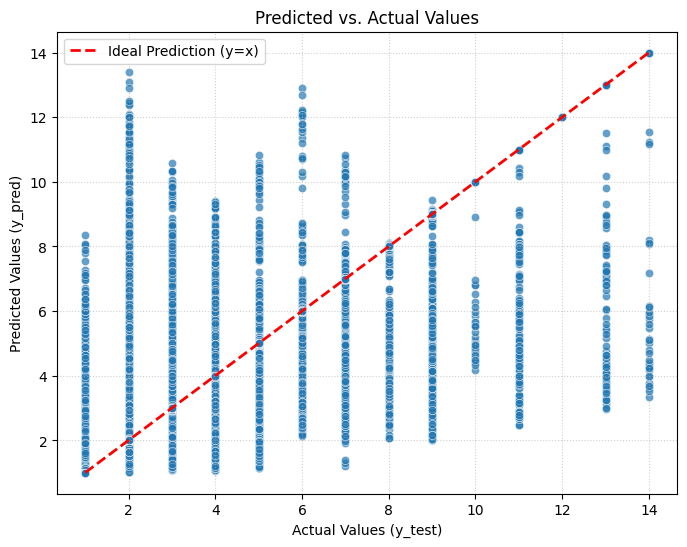

In [117]:
residuals = y_test - y_pred


plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label='Ideal Prediction (y=x)')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()


In [ ]:
import joblib

joblib.dump(model, 'model.pkl', compress=3)
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'encoders.pkl')
joblib.dump(elasticity_model, 'elasticity_model.pkl', compress=9)


['elasticity_model.pkl']

relationship between log(Price) and log(Quantity) colored by customer segment.

c:\Program Files\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


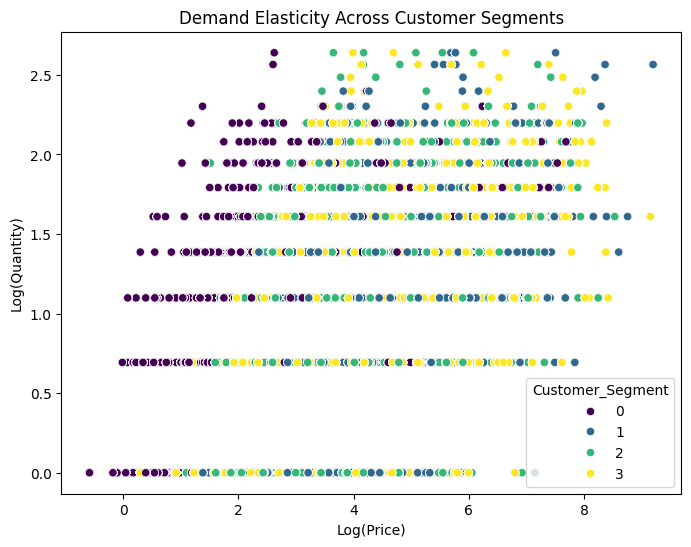

In [119]:
# Plot the relationship between log(Price) and log(Quantity) colored by customer segment.
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='log_Price', y='log_Quantity', hue='Customer_Segment', palette='viridis')
plt.title("Demand Elasticity Across Customer Segments")
plt.xlabel("Log(Price)")
plt.ylabel("Log(Quantity)")
plt.show()